# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [74]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation

# [1]. Reading Data

In [75]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\\TGM\\ML\\AmazonFineFoodReviews\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [76]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [77]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [78]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [79]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [80]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [81]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [82]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [83]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [84]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [85]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [86]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [87]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [88]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [89]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [90]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [91]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [92]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [93]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [94]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [95]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:04<00:00, 1195.86it/s]


In [96]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [97]:
final['cleaned_text']=preprocessed_reviews

In [98]:
final.shape

(364171, 11)

In [99]:
final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [100]:
#Getting positive and negetive data
data_pos = final[final["Score"] == 1].sample(n = 50000)
data_neg = final[final["Score"] == 0].sample(n = 50000)
final1 = pd.concat([data_pos, data_neg])
final1.shape

(100000, 11)

In [101]:
#Sorted the data based on time and took 100k data points
final1["Time"] = pd.to_datetime(final1["Time"], unit = "s")
final1 = final1.sort_values(by = "Time")
final1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...
417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,2001-06-11,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,michael keaton brings no distinguishing charac...
346037,374339,B00004CI84,AZRJH4JFB59VC,Lynwood E. Hines,21,23,0,2001-08-08,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,continually amazed shoddy treatment movies get...
346031,374333,B00004CI84,A1CZICCYP2M5PX,Christian Pelchat,0,0,1,2002-02-07,An entertaining odd fantasy comedy.,When Two Couple (Geena Davis & Alec Baldwin) d...,two couple geena davis alec baldwin died car a...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [102]:
Y = final1['Score'].values
X = final1['cleaned_text'].values
print(Y.shape)
print(type(Y))
print(X.shape)
print(type(X))

(100000,)
<class 'numpy.ndarray'>
(100000,)
<class 'numpy.ndarray'>


In [103]:
# split the data set into train and test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y,test_size=0.3, random_state=12, shuffle = False)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X,Y, test_size=0.3, random_state=12, shuffle = False)

print('='*100)
print("After splitting")
print("X_Train Shape:",X_Train.shape, "Y_Train Shape:",Y_Train.shape)
print("X_cv Shape:",X_cv.shape,       "Y_cv Shape",Y_cv.shape)
print("X_Test Shape",X_Test.shape,    "Y_Test Shape",Y_Test.shape)

After splitting
X_Train Shape: (70000,) Y_Train Shape: (70000,)
X_cv Shape: (30000,) Y_cv Shape (30000,)
X_Test Shape (30000,) Y_Test Shape (30000,)


# <font color = Red>[4] Featurization</font>

## <font color = Green>[4.1] Bag Of Words</font>

In [104]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_Train)
print("some feature names ", count_vect.get_feature_names()[:10])
X_Train_Bow = count_vect.transform(X_Train)
X_Test_Bow = count_vect.transform(X_Test)
X_CV_Bow = count_vect.transform(X_cv)

print('='*50)

#final_counts = count_vect.transform(X_Test)

print("the type of X Train : ",type(X_Train_Bow))
print("the shape of Train BOW vectorizer ",X_Train_Bow.get_shape())
print("the shape of Test BOW vectorizer ",X_Test_Bow.get_shape())
print("the shape of CV BOW vectorizer ",X_CV_Bow.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaaallll', 'aaaand', 'aaah']
the type of X Train :  <class 'scipy.sparse.csr.csr_matrix'>
the shape of Train BOW vectorizer  (70000, 51472)
the shape of Test BOW vectorizer  (30000, 51472)
the shape of CV BOW vectorizer  (30000, 51472)


### <font color=blue>[4.1.1] AUC Curve Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.83it/s]


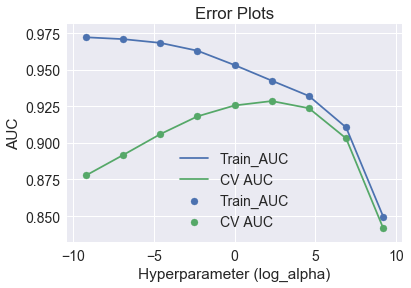

In [105]:
import math
from sklearn.naive_bayes import MultinomialNB

train_AUC = []
CV_AUC = []
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 1,10**1, 10**2, 10**3, 10**4]
log_alpha=[]

for i in tqdm(alpha):
    MNB = MultinomialNB(alpha = i, class_prior=[0.5,0.5], fit_prior=True)
    #fit a model on train BOW vectorizer
    MNB.fit(X_Train_Bow, Y_Train)
    #predict probabilities on train BOW vectorizer
    Y_Train_Pred = MNB.predict_proba(X_Train_Bow)[:,1]
    #predict probabilities on Cross validation BOW vectorizer
    Y_CV_Pred = MNB.predict_proba(X_CV_Bow)[:,1]
    #calculate AUC score
    train_AUC.append(roc_auc_score(Y_Train,Y_Train_Pred))
    CV_AUC.append(roc_auc_score(Y_cv, Y_CV_Pred))
    log_alpha.append(math.log(i))
        
plt.plot(log_alpha, train_AUC, label='Train_AUC')
plt.scatter(log_alpha, train_AUC, label='Train_AUC')
plt.plot(log_alpha, CV_AUC, label='CV AUC')
plt.scatter(log_alpha, CV_AUC, label='CV AUC')
plt.legend()
plt.xlabel('Hyperparameter (log_alpha)')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

In [106]:
 #Finding the best hyper paramter using 10-fold cross validation data
def Optimal_Alpha(X_Train, Y_Train):
         #Considered a wide range of alpha values for hyperparameter tuning, start as low 10^-4 to 10^4.
        alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
        # empty list that will hold cv scores
        cv_scores = []

        # perform 10-fold cross validation
        for i in tqdm(alpha):
            MNB = MultinomialNB(alpha=i, class_prior=[0.5,0.5], fit_prior=True)
            scores = cross_val_score(MNB, X_Train, Y_Train, cv=10, scoring='roc_auc')
            cv_scores.append(scores.mean())

        # changing to misclassification error
        MSE = [1 - x for x in cv_scores]

        # determining best k
        bestAlpha = alpha[MSE.index(min(MSE))]
        print('\nThe optimal number of neighbors is %d.' % bestAlpha)

        # plot misclassification error vs k 
        plt.plot(alpha, MSE)

        for xy in zip(alpha, np.round(MSE,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Misclassification Error')
        plt.show()

        print("the misclassification error for each k value is : ", np.round(MSE,3))
        return bestAlpha

### <font color=blue>[4.1.2] 10-fold cross validation, determining best Alpha</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.13s/it]



The optimal number of neighbors is 10.


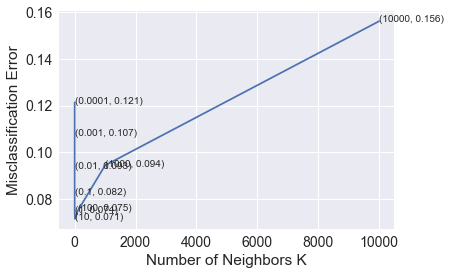

the misclassification error for each k value is :  [0.121 0.107 0.093 0.082 0.074 0.071 0.075 0.094 0.156]
____________________________________________________________________________________________________
optimal_alpha: 10
____________________________________________________________________________________________________


In [107]:
optimal_alpha_bow = Optimal_Alpha(X_Train_Bow, Y_Train)
print("_"*100)
print("optimal_alpha:", optimal_alpha_bow)
print("_"*100)

In [108]:
optimal_model = MultinomialNB(alpha=optimal_alpha_bow, class_prior=[0.5,0.5], fit_prior=True)
optimal_model.fit(X_Train_Bow, Y_Train)
prediction = optimal_model.predict(X_Test_Bow)
optimal_model

MultinomialNB(alpha=10, class_prior=[0.5, 0.5], fit_prior=True)

### <font color = blue>[4.1.3] ROC Curve of Naive Bayes</font>

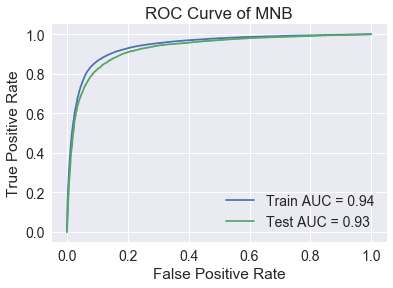

In [109]:
#with the reference of below link: 
#https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
#predict probabilities on X_Train_Bow and X_Test_Bow and pass as param to roc_curve to find roc curve
Train_FPR, Train_TPR, threshold = roc_curve(Y_Train, optimal_model.predict_proba(X_Train_Bow)[:,1])
Test_FPR, Test_TPR, threshold = roc_curve(Y_Test, optimal_model.predict_proba(X_Test_Bow)[:,1])
roc_auc = auc(Train_FPR, Train_TPR)
roc_auc1 = auc(Test_FPR, Test_TPR)

plt.plot(Train_FPR, Train_TPR, label = 'Train AUC = %0.2f' % roc_auc)
plt.plot(Test_FPR, Test_TPR, label = 'Test AUC = %0.2f' % roc_auc1)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MNB')
plt.show()

### <font color = blue>[4.1.4]Train and Test Accuracy</font>

In [110]:
Training_Accuracy_Bow = optimal_model.score(X_Train_Bow, Y_Train)
print('Training_Accuracy=%0.3f'%Training_Accuracy_Bow)
Training_Error_Bow = 1 - Training_Accuracy_Bow
print('Training_Error=%0.3f'%Training_Error_Bow)

Test_Accuracy_Bow = accuracy_score(Y_Test, prediction)
print('Test_Accuracy=%0.3f'%Test_Accuracy_Bow)
Test_Error_Bow = 1 - Test_Accuracy_Bow
print('Test_Error=%0.3f'%Test_Error_Bow)
print('\nThe accuracy of the MNB classifier for k = %d is %f%%' % (optimal_alpha_bow, Test_Accuracy_Bow))

Training_Accuracy=0.882
Training_Error=0.118
Test_Accuracy=0.865
Test_Error=0.135

The accuracy of the MNB classifier for k = 10 is 0.864900%


### <font color = blue>[4.1.5] Confusion Matrix </font>

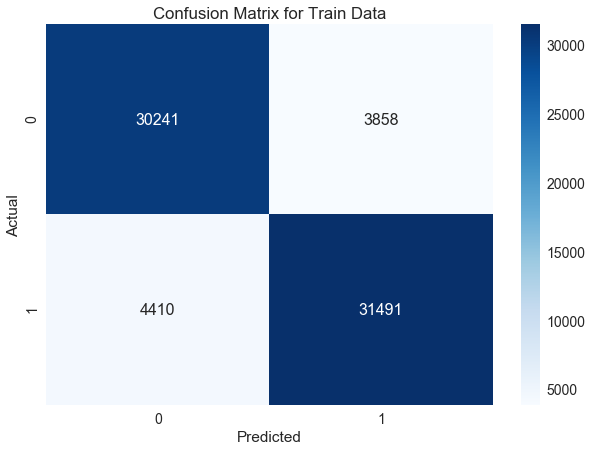

In [111]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Train, optimal_model.predict(X_Train_Bow))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Train), index=np.unique(Y_Train))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Train Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

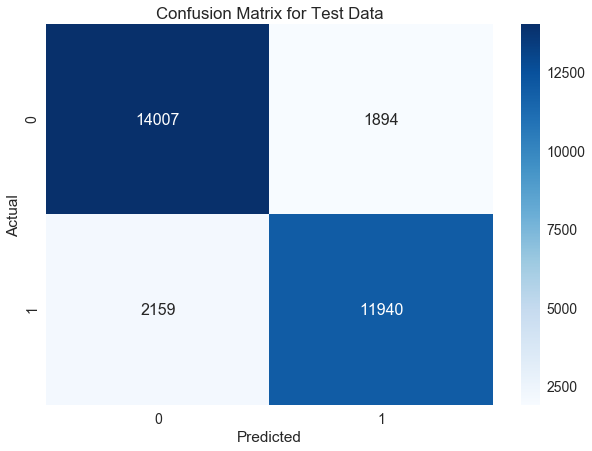

In [112]:
#With the reference of below link:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Test, optimal_model.predict(X_Test_Bow))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Test), index=np.unique(Y_Test))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Test Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

### <font color = blue>[4.1.6] Classification Report</font>

In [113]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test, prediction))

             precision    recall  f1-score   support

          0       0.87      0.88      0.87     15901
          1       0.86      0.85      0.85     14099

avg / total       0.86      0.86      0.86     30000



## <font color = Green>[4.2] TF-IDF</font>

In [114]:
#TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit_transform(X_Train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_Train_TfIdf = tf_idf_vect.transform(X_Train)
X_Test_TfIdf = tf_idf_vect.transform(X_Test)
X_CV_TfIdf = tf_idf_vect.transform(X_cv)

#final_tf_idf = tf_idf_vect.transform(X_Test)
print("the type of count vectorizer ",type(X_Train_TfIdf))
print("the shape of out text TFIDF vectorizer ",X_Train_TfIdf.get_shape())
print("the shape of out text TFIDF vectorizer ",X_Test_TfIdf.get_shape())
print("the shape of out text TFIDF vectorizer ",X_CV_TfIdf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aafco', 'aback', 'abandon', 'abandoned', 'abbey', 'abc', 'abdomen', 'abdominal']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70000, 92735)
the shape of out text TFIDF vectorizer  (30000, 92735)
the shape of out text TFIDF vectorizer  (30000, 92735)


### <font color = blue>[4.2.1] AUC Curve Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.69it/s]


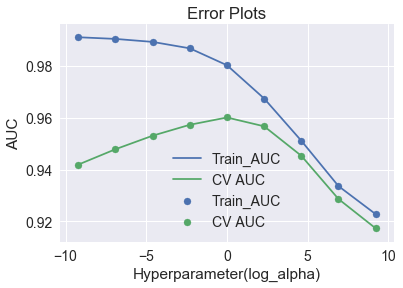

In [115]:
import math
from sklearn.naive_bayes import MultinomialNB

train_AUC = []
CV_AUC = []
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 1,10**1, 10**2, 10**3, 10**4]
log_alpha_tfidf=[]

for i in tqdm(alpha):
    MNB = MultinomialNB(alpha = i, class_prior=[0.5,0.5], fit_prior=True)
    #fit a model on train BOW vectorizer
    MNB.fit(X_Train_TfIdf, Y_Train)
    #predict probabilities on train BOW vectorizer
    Y_Train_Pred = MNB.predict_proba(X_Train_TfIdf)[:,1]
    #predict probabilities on Cross validation BOW vectorizer
    Y_CV_Pred = MNB.predict_proba(X_CV_TfIdf)[:,1]
    #calculate AUC score
    train_AUC.append(roc_auc_score(Y_Train,Y_Train_Pred))
    CV_AUC.append(roc_auc_score(Y_cv, Y_CV_Pred))
    log_alpha_tfidf.append(math.log(i))
        
plt.plot(log_alpha_tfidf, train_AUC, label='Train_AUC')
plt.scatter(log_alpha_tfidf, train_AUC, label='Train_AUC')
plt.plot(log_alpha_tfidf, CV_AUC, label='CV AUC')
plt.scatter(log_alpha_tfidf, CV_AUC, label='CV AUC')
plt.legend()
plt.xlabel('Hyperparameter(log_alpha)')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

### <font color=blue>[4.2.2] 10-fold cross validation, determining best Alpha</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.76s/it]



The optimal number of neighbors is 1.


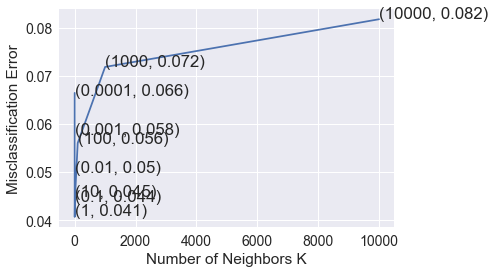

the misclassification error for each k value is :  [0.066 0.058 0.05  0.044 0.041 0.045 0.056 0.072 0.082]
optimal_alpha: 1


In [116]:
optimal_alpha_tfidf = Optimal_Alpha(X_Train_TfIdf, Y_Train)
print("optimal_alpha:", optimal_alpha_tfidf)

In [117]:
optimal_model1 = MultinomialNB(alpha=optimal_alpha_tfidf, class_prior=[0.5,0.5], fit_prior=True)
optimal_model1.fit(X_Train_TfIdf, Y_Train)
prediction = optimal_model1.predict(X_Test_TfIdf)

### <font color = blue>[4.2.3] ROC Curve of Naive Bayes</font>

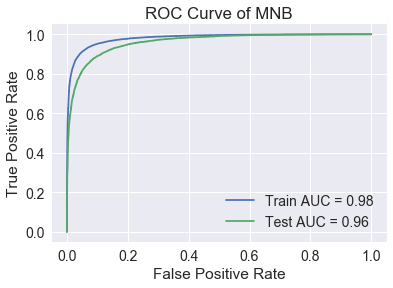

In [118]:
#with the reference of below link: 
#https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
#predict probabilities on X_Train_Bow and X_Test_Bow and pass as param to roc_curve to find roc curve
Train_FPR, Train_TPR, threshold = roc_curve(Y_Train, optimal_model1.predict_proba(X_Train_TfIdf)[:,1])
Test_FPR, Test_TPR, threshold = roc_curve(Y_Test, optimal_model1.predict_proba(X_Test_TfIdf)[:,1])
roc_auc2 = auc(Train_FPR, Train_TPR)
roc_auc3 = auc(Test_FPR, Test_TPR)

plt.plot(Train_FPR, Train_TPR, label = 'Train AUC = %0.2f' % roc_auc2)
plt.plot(Test_FPR, Test_TPR, label = 'Test AUC = %0.2f' % roc_auc3)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MNB')
plt.show()

### <font color = blue>[4.2.4]Train and Test Accuracy</font>

In [119]:
Training_Accuracy_tfidf = optimal_model1.score(X_Train_TfIdf, Y_Train)
print('Training_Accuracy=%0.3f'%Training_Accuracy_tfidf)
Training_Error_tfidf = 1 - Training_Accuracy_tfidf
print('Training_Error=%0.3f'%Training_Error_tfidf)

Test_Accuracy_tfidf = accuracy_score(Y_Test, prediction)
print('Test_Accuracy=%0.3f'%Test_Accuracy_tfidf)
Test_Error_tfidf = 1 - Test_Accuracy_tfidf
print('Test_Error=%0.3f'%Test_Error_tfidf)
print('\nThe accuracy of the MNB classifier for k = %d is %f%%' % (optimal_alpha_tfidf, Test_Accuracy_tfidf))

Training_Accuracy=0.931
Training_Error=0.069
Test_Accuracy=0.895
Test_Error=0.105

The accuracy of the MNB classifier for k = 1 is 0.895233%


### <font color = blue>[4.2.5] Confusion Matrix </font>

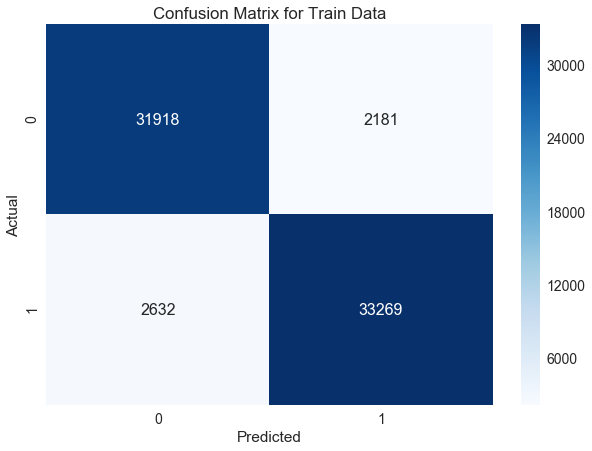

In [120]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Train, optimal_model1.predict(X_Train_TfIdf))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Train), index=np.unique(Y_Train))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Test), index=np.unique(Y_Test))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Train Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

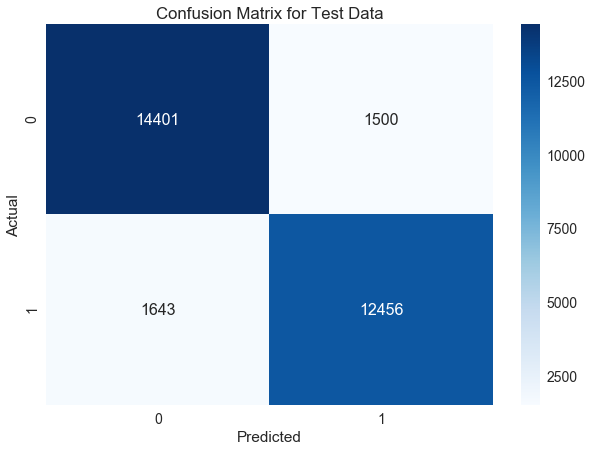

In [121]:
#With the reference of below link:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Test, optimal_model1.predict(X_Test_TfIdf))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Test), index=np.unique(Y_Test))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Test Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

### <font color = blue>[4.2.6]Classification Report </font>

In [122]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test, prediction))

             precision    recall  f1-score   support

          0       0.90      0.91      0.90     15901
          1       0.89      0.88      0.89     14099

avg / total       0.90      0.90      0.90     30000



## <font color = Red>[5] Feature Importance </font>

### <font color = Green>[5.1]BoW</font>

### <font color = blue>[5.1.1]Feature Importance for Positive Class</font>

In [123]:
#https://stackoverflow.com/questions/35353150/sklearn-multinomialnb-how-to-find-most-distinguish-word-in-class
import operator
pos_imp_features = MNB.feature_log_prob_[1,:]
neg_imp_features = MNB.feature_log_prob_[0,:]
print("pos_imp_features",len(pos_imp_features))
imp_features = {}
feature_names= count_vect.get_feature_names()
print("feature_names",len(feature_names))
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 25 important features are:")
for i in range(25):
    print(names_diff_sorted[i])

pos_imp_features 92735
feature_names 51472
Postive top 25 important features are:
('pupils', -11.36733577032401)
('portugal', -11.376557440094475)
('sueggestion', -11.38457326712038)
('touches', -11.384717570341618)
('eventhe', -11.387648758776214)
('mucus', -11.395026781036709)
('caseits', -11.398145828536254)
('aromaticum', -11.401794080610495)
('minnesotans', -11.40278108425811)
('patronize', -11.404991654726802)
('terible', -11.407241317216132)
('notgrab', -11.407434579080615)
('andexpected', -11.409008854163199)
('unfortunatedly', -11.40912985959799)
('eic', -11.410060700688014)
('havesomething', -11.410297156549989)
('curative', -11.410541993801118)
('cement', -11.412547064243359)
('ivf', -11.413818900871217)
('oligofructose', -11.414011561257972)
('ordinairy', -11.414444626592093)
('truthaboutpetfood', -11.414916458198851)
('medifast', -11.415195577824997)
('implemented', -11.41590031352609)
('leek', -11.416330419652333)


### <font color = blue>[5.1.2]Feature Importance for Negetive Class</font>

In [124]:
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 25 important features are:")
for i in range(25):
    print(names_diff_sorted[i])



Negative top 25 important features are:
('sueggestion', -11.370150161443856)
('eventhe', -11.39072028377526)
('mucus', -11.396886574131914)
('portugal', -11.399387104745102)
('curative', -11.4027792525322)
('leek', -11.404987007226316)
('patronize', -11.405735198438393)
('aromaticum', -11.405991007765396)
('complainingsince', -11.407246406855636)
('notgrab', -11.407902666580782)
('colgin', -11.409226508302964)
('boson', -11.409860317452424)
('fudge', -11.409926980310622)
('eic', -11.41088133161944)
('hunting', -11.41329207617512)
('cement', -11.413351001752769)
('xylan', -11.413439178898727)
('moneys', -11.414438331464124)
('ivf', -11.415050398946581)
('procuct', -11.415477110020493)
('uji', -11.415754640459634)
('brainwashing', -11.41625069673083)
('soulful', -11.417110369095674)
('implemented', -11.417996791859633)
('touches', -11.418000951237648)


### <font color = Green>[5.2]TF-IDF</font>

### <font color = blue>[5.2.1]Feature Importance for Positive Class</font>

In [125]:
#https://stackoverflow.com/questions/35353150/sklearn-multinomialnb-how-to-find-most-distinguish-word-in-class

pos_imp_features = MNB.feature_log_prob_[1,:]
print("length of pos_imp_features:",len(pos_imp_features))
imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
print("length of feature_names:",len(feature_names))
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
#Introduced exception handling to avoid the index error. 
  #  try:
  #      imp_features[feature_names[i]] = pos_imp_features[i]
  #  except IndexError as error:
  #      pass
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 25 important features are:\n")
for i in range(25):
    print(names_diff_sorted[i])

length of pos_imp_features: 92735
length of feature_names: 92735
Postive top 25 important features are:

('not', -11.35577541247079)
('great', -11.36733577032401)
('good', -11.376557440094475)
('tea', -11.38302202715892)
('like', -11.38457326712038)
('love', -11.384717570341618)
('coffee', -11.387648758776214)
('one', -11.393973886250503)
('product', -11.394467023374107)
('taste', -11.394784644046778)
('flavor', -11.395026781036709)
('best', -11.398145828536254)
('amazon', -11.401794080610495)
('find', -11.40278108425811)
('price', -11.403080957515396)
('would', -11.403876351494166)
('use', -11.404032250369402)
('really', -11.40434932692268)
('get', -11.404991654726802)
('little', -11.407241317216132)
('food', -11.407434579080615)
('time', -11.407806419298154)
('no', -11.408174829534856)
('much', -11.408314533103715)
('also', -11.409008854163199)


### <font color = blue>[5.2.2]Feature Importance for Negetive Class</font>

In [126]:
neg_imp_features = MNB.feature_log_prob_[0,:]
print("length of neg_imp_features:",len(neg_imp_features))
print("length of feature_names:",len(feature_names))
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
   # try:
    #    imp_features[feature_names[i]] = neg_imp_features[i]
   # except IndexError as error:
    #    pass
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 25 important features are:\n")
for i in range(25):
    print(names_diff_sorted[i])

length of neg_imp_features: 92735
length of feature_names: 92735


Negative top 25 important features are:

('not', -11.300193735430538)
('like', -11.370150161443856)
('taste', -11.378288708636068)
('product', -11.378325867831162)
('would', -11.380567943280552)
('coffee', -11.39072028377526)
('one', -11.391367231022137)
('flavor', -11.396886574131914)
('no', -11.397739097994315)
('good', -11.399387104745102)
('tea', -11.400843728957796)
('buy', -11.4027792525322)
('even', -11.404987007226316)
('get', -11.405735198438393)
('amazon', -11.405991007765396)
('box', -11.407246406855636)
('food', -11.407902666580782)
('much', -11.408213972903438)
('really', -11.408786770340077)
('bought', -11.409226508302964)
('bad', -11.409860317452424)
('could', -11.409926980310622)
('chocolate', -11.41088133161944)
('tried', -11.411338134884247)
('disappointed', -11.41329207617512)


In [127]:
from prettytable import PrettyTable
comparision = PrettyTable()
comparision.field_names = ["S.NO","Vectorizer", "Hyperparameter", "Training Error", "Test Error","AUC"]
comparision.add_row(["1","BoW", optimal_alpha_bow, Training_Error_Bow, Test_Error_Bow, np.round(float(roc_auc1),3)])
comparision.add_row(["2","TF-IDF", optimal_alpha_tfidf,Training_Error_tfidf, Test_Error_tfidf, np.round(float(roc_auc3),3)])
print(comparision)

+------+------------+----------------+---------------------+---------------------+-------+
| S.NO | Vectorizer | Hyperparameter |    Training Error   |      Test Error     |  AUC  |
+------+------------+----------------+---------------------+---------------------+-------+
|  1   |    BoW     |       10       | 0.11811428571428573 |        0.1351       | 0.929 |
|  2   |   TF-IDF   |       1        | 0.06875714285714285 | 0.10476666666666667 |  0.96 |
+------+------------+----------------+---------------------+---------------------+-------+


# <font color = Green>Conclusion</font>

1. Applied Multinomial NB on two feature sets 1. Bow and 2. TF-IDF vectorizer.
2. Sorted the data based on Time and Considered 100 K data points for Training set 70K, Test set: 30K
3. Used AUC as a metric for hyperparameter tuning. And took the range of alpha values from (10^-4 to 10^4).
4. Found the top 25 features of positive class and top 25 features of negative class for Bow and TF-IDF feature sets.
5. With reference to the pretty table, here is my understanding:
    a. Naive Bayes by using Bow and TF-IDF with best alpha = 10 and AUC score is 0.92 in both.
6. Since it is an imbalanced data, not considered accuracy as a metric and AUC Score is high 
7. Plotted Confusion matrix for both Training and Test set.


Note: I do not have idea on feature engineering concept, One after completing the Module 5 and able to check the accuracy of this model with feature engineering.